# LIBRARY

In [2]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np

from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D




# GET DATA

In [8]:
yf.pdr_override()
tickers = ["ANTM.JK","ASII.JK","ICBP.JK","JSMR.JK"]

stock = 'ANTM.JK'
today = date.today()
# print(today)
start_date = '2010-01-01'
# end_date = '2022-08-02'

panel_data = pdr.get_data_yahoo(tickers,start=start_date, end=today)
panel_data.head(5)


[*********************100%***********************]  4 of 4 completed


Adj Close                                               Close  \
                ANTM.JK      ASII.JK      ICBP.JK      JSMR.JK      ANTM.JK   
Date                                                                          
2010-01-04  1576.277344  2421.051025  1408.558960  1530.937866  1931.946777   
2010-01-05  1576.277344  2434.768066  1437.305054  1547.488647  1931.946777   
2010-01-06  1576.277344  2421.051025  1427.723145  1555.763916  1931.946777   
2010-01-07  1610.544312  2345.607422  1437.305054  1547.488647  1973.945557   
2010-01-08  1610.544312  2359.324707  1446.887451  1539.213135  1973.945557   

                                                High          ...     Low  \
           ASII.JK ICBP.JK      JSMR.JK      ANTM.JK ASII.JK  ... ICBP.JK   
Date                                                          ...           
2010-01-04  3530.0  1837.5  1845.677368  1931.946777  3550.0  ...  1762.5   
2010-01-05  3550.0  1875.0  1865.630737  1994.945068  3570.0  ...  1825.0   
2010-01-06  3530.0  1862.5  1875.607300  1994.945068  3580.0  ...  1862.5   
2010-01-07  3420.0  1875.0  1865.630737  1994.945068  3560.0  ...  1862.5   
2010-01-08  3440.0  1887.5  1855.654053  1994.945068  3450.0  ...  1862.5   

                                Open                                 Volume  \
                JSMR.JK      ANTM.JK ASII.JK ICBP.JK      JSMR.JK   ANTM.JK   
Date                                                                          
2010-01-04  1805.770874  1931.946777  3530.0  1787.5  1845.677368  39619544   
2010-01-05  1845.677368  1931.946777  3550.0  1875.0  1865.630737  62041590   
2010-01-06  1855.654053  1931.946777  3530.0  1900.0  1875.607300  30916328   
2010-01-07  1845.677368  1973.945557  3420.0  1875.0  1865.630737  30624653   
2010-01-08  1845.677368  1973.945557  3440.0  1900.0  1855.654053  15857579   

                                       
           ASII.JK   ICBP.JK  JSMR.JK  
Date                                   
2010-01-04      40  26442000  6978806  
2010-01-05      40  42874000  7988164  
2010-01-06      40  44946000  7538113  
2010-01-07      40  24863000  2048787  
2010-01-08      40  19118000  2441705  

[5 rows x 24 columns]

In [7]:
data_volume = panel_data["Volume"]
list(data_volume)
data_volume.columns = ['antm', 'asii', 'icbp', 'jsmr']
data_volume.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,antm,asii,icbp,jsmr
count,3116.00000,3116.00000,3116.00000,3116.00000
mean,80351245.95186,35639819.25770,9255544.62837,7709555.85077
std,155186171.25415,24029907.07991,17256382.91191,8105828.56457
min,0.00000,0.00000,0.00000,0.00000
25%,13882346.00000,21383425.00000,3096450.00000,3551575.00000
50%,36319950.00000,30595350.00000,5206550.00000,5860450.00000
75%,83556025.00000,44622500.00000,8967150.00000,9424575.00000
max,2186652700.00000,311402400.00000,570465000.00000,188892300.00000


In [5]:
data_close = panel_data["Adj Close"]
list(data_close)
data_close.columns = ['antm', 'asii', 'icbp', 'jsmr']
data_close.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,antm,asii,icbp,jsmr
count,3225.00000,3225.00000,3225.00000,3225.00000
mean,1130.94090,5535.38049,6108.67067,4489.46089
std,576.18313,1103.17964,2825.91029,1157.56689
min,274.09692,2290.73999,1283.99255,1398.53223
25%,740.15723,4960.83838,3946.94458,3770.00000
50%,929.10339,5624.34521,7099.00928,4573.74219
75%,1440.12781,6326.53076,8323.28125,5276.22754
max,3117.91113,7761.65479,11525.49219,6832.19678


# PLOT SEMUA SAHAM

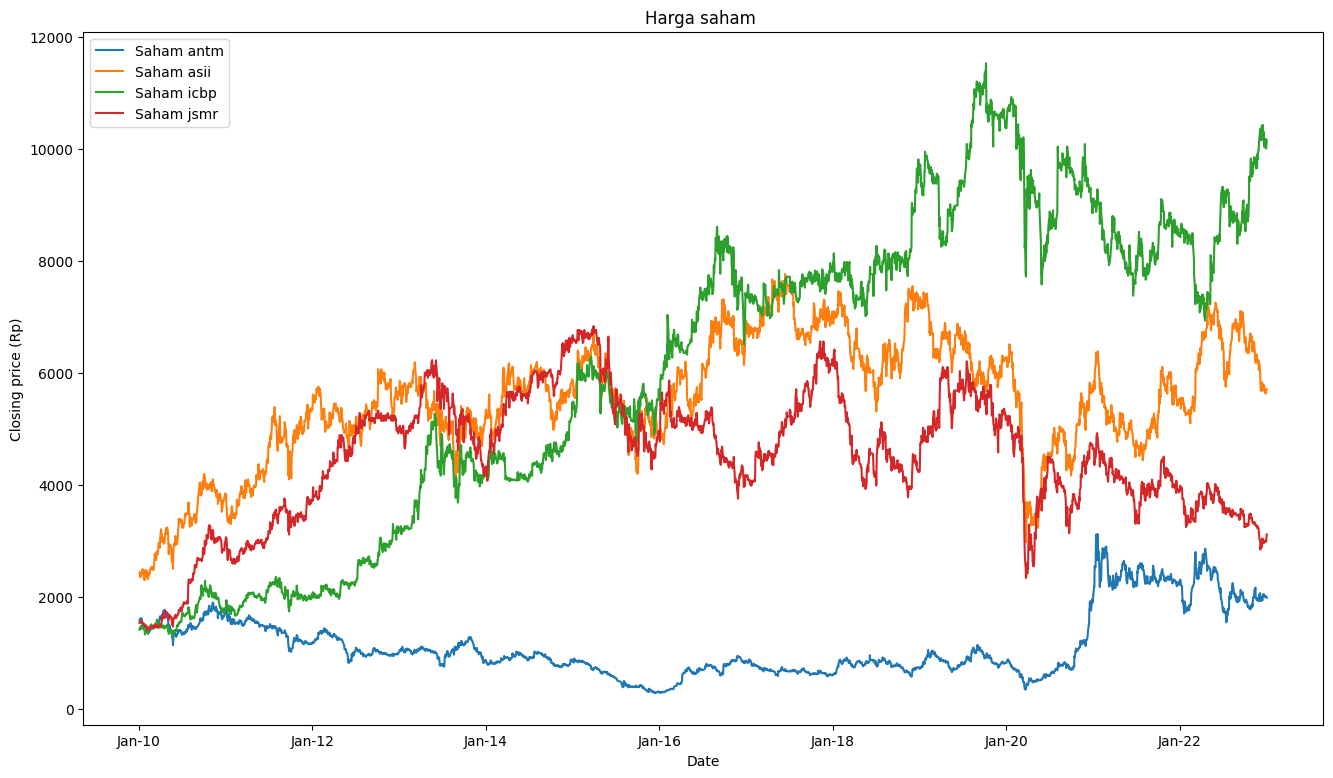

In [6]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

for name in ['antm', 'asii', 'icbp', 'jsmr']:
    ax.plot(data_close[name].index, data_close[name], label='Saham {}'.format(name))


# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

# Normalize data

In [7]:
from sklearn.preprocessing import MinMaxScaler
def normalize_data(df_data, COLUMN_NAME):
    scaler = MinMaxScaler()
    df_data = pd.DataFrame(df_data)
    df_data = pd.DataFrame(scaler.fit_transform(df_data), columns = [COLUMN_NAME])
    return df_data


In [8]:
df_asii = normalize_data(data_close.asii,'asii')
df_icbp = normalize_data(data_close.icbp, 'icbp')
df_jsmr = normalize_data(data_close.jsmr, 'jsmr')

# SLIDING WINDOW FUNCTION

In [9]:
from numpy import array

def split_sequence(seq, n_steps):
    X,y = list(), list()
    for i in range(len(seq)):
        end_ix = i + n_steps
        if end_ix > len(seq)-1:
            break
        seq_x, seq_y =seq[i:end_ix],seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# RESET INDEX FUNCTION

In [10]:
from sklearn.model_selection import train_test_split
def reset_index_data(df_data):
    df_data = df_data.reset_index(drop=True)
    arr_df = df_data.to_numpy()
    flat_df = arr_df.flatten()
    return flat_df

# RESHAPE DATA FUNC

In [11]:
def reshape_data(X,N_FEATURES):
    X = X.reshape(X.shape[0],X.shape[1],N_FEATURES)
    return X

# TRAIN VANILA MODEL FUCTION

In [12]:
def train_lstm(X_train,y_train,config):
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_vanila_lstm = Sequential([
    LSTM(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_vanila_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    model_vanila_lstm.summary()
    history_vanila_lstm = model_vanila_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          shuffle = True
    )

    return model_vanila_lstm, history_vanila_lstm

#time 41.8
    

In [13]:
def train_vanila_lstm(X_train,y_train,config):
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_vanila_lstm = Sequential([
    LSTM(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_vanila_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_vanila_lstm.summary()
    history_vanila_lstm = model_vanila_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_vanila_lstm, history_vanila_lstm

#time 41.8
    

# ROUNDUP FUNCTION

In [14]:
def pembulatan(data,number):
    return np.round(data,number)

# MATRICS EVALUTE

In [15]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
def matriks_evaluate(preds,y_test, lb_saham, number):
    print('Matriks score for '+ lb_saham)
    print("mae score: "+str(mean_absolute_error(preds, y_test)))
    print("r2 score "+str(r2_score(preds, y_test)))
    print("mape score "+str(mean_absolute_percentage_error(preds, y_test)))
    print("rmse score "+str(np.sqrt(mean_squared_error(preds, y_test))))
    print("round_up")
    print("mae score: "+str(pembulatan(mean_absolute_error(preds, y_test),number)))
    print("r2 score "+str(pembulatan(r2_score(preds, y_test),number)))
    print("mape score "+str(pembulatan(mean_absolute_percentage_error(preds, y_test),number)))
    print("rmse score "+str(pembulatan(np.sqrt(mean_squared_error(preds, y_test)),number)))

# PLOT FUNCTION

In [16]:
def plot_metriks(data,title):
    names = list(data.keys())
    values = list(data.values())
    plt.title(title)
    plt.bar(range(len(data)), values, tick_label=names)
    plt.show()

# VANILA LSTM

## ANTM

In [17]:
#get data and normalize data
df_antm = normalize_data(data_close.antm,'antm')
#reset index
df_antm = reset_index_data(df_antm)
#data to supervised
antm_X, antm_y = split_sequence(df_antm, 2)
#split to train and test
X_train_antm, X_test_antm, y_train_antm, y_test_antm = train_test_split(antm_X, antm_y, test_size=0.33, random_state=42)

X_train_antm = reshape_data(X_train_antm,1)
X_test_antm = reshape_data(X_test_antm,1)


In [18]:
cfg_antm = [8,'relu',2,1,0.1,8,200]
model_antm,history_antm_model,  = train_vanila_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
216/216 [==============================] - 3s 5ms/step - loss: 0.0334 - mae: 0.0334 - val_loss: 0.0222 - val_mae: 0.0222
Epoch 2/200
216/216 [==============================] - 1s 3ms/step - loss: 0.0207 - mae: 0.0207 - val_loss: 0.0125 - val_mae: 0.0125
Epoch 3/200
216/216 [==============================] - 1s 3ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0178 - val_mae: 0.0178
Epoch 4/200
216/216 [==============================] - 

In [19]:
preds_antm = model_antm.predict(X_test_antm)
matriks_evaluate(preds_antm,y_test_antm,'antm',4)

34/34 [==============================] - 0s 1ms/step
Matriks score for antm
mae score: 0.01075447862284689
r2 score 0.9940625098496625
mape score 0.055718417672200746
rmse score 0.015348847402380841
round_up
mae score: 0.0108
r2 score 0.9941
mape score 0.0557
rmse score 0.0153


In [20]:
preds_antm_train = model_antm.predict(X_train_antm)
matriks_evaluate(preds_antm_train,y_train_antm,'antm',4)

68/68 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.010975655895538932
r2 score 0.9931168033791961
mape score 0.060043078595348985
rmse score 0.015916690101335316
round_up
mae score: 0.011
r2 score 0.9931
mape score 0.06
rmse score 0.0159


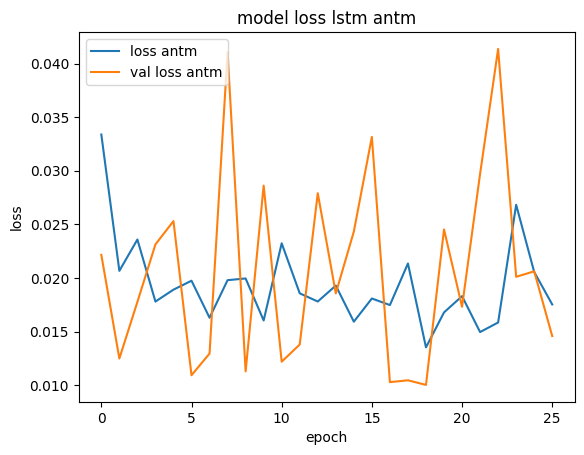

In [21]:
plt.plot(history_antm_model.history['loss'], label='loss antm')
plt.plot(history_antm_model.history['val_loss'], label = 'val loss antm')
plt.title('model loss lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm', dpi=3600)

## ASII

In [22]:
#get data and normalize data
df_asii = normalize_data(data_close.asii,'asii')
#reset index
df_asii = reset_index_data(df_asii)
#data to supervised
asii_X, asii_y = split_sequence(df_asii, 3)
#split to train and test
X_train_asii, X_test_asii, y_train_asii, y_test_asii = train_test_split(asii_X, asii_y, test_size=0.33, random_state=42)

X_train_asii = reshape_data(X_train_asii,1)
X_test_asii = reshape_data(X_test_asii,1)


In [23]:
cfg_asii = [32,'relu',3,1,0.01,8,150]
model_asii,history_asii_model,  = train_vanila_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
216/216 [==============================] - 3s 4ms/step - loss: 0.0436 - mae: 0.0436 - val_loss: 0.0234 - val_mae: 0.0234
Epoch 2/150
216/216 [==============================] - 1s 3ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0292 - val_mae: 0.0292
Epoch 3/150
216/216 [==============================] - 1s 3ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0218 - val_mae: 0.0218
Epoch 4/150
216/216 [============================

In [24]:
preds_asii = model_asii.predict(X_test_asii)
matriks_evaluate(preds_asii,y_test_asii,'asii',4)

34/34 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.015356228959468214
r2 score 0.9897782633935417
mape score 0.03388978778369457
rmse score 0.02026853194562577
round_up
mae score: 0.0154
r2 score 0.9898
mape score 0.0339
rmse score 0.0203


In [25]:
preds_asii_train = model_asii.predict(X_train_asii)
matriks_evaluate(preds_asii_train,y_train_asii,'asii',4)

68/68 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.015685107357574425
r2 score 0.9891866035535912
mape score 0.03396726797326113
rmse score 0.020974669281089046
round_up
mae score: 0.0157
r2 score 0.9892
mape score 0.034
rmse score 0.021


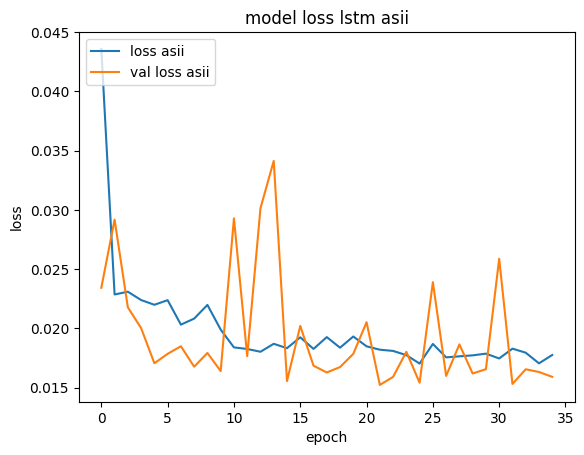

In [26]:
plt.plot(history_asii_model.history['loss'], label='loss asii')
plt.plot(history_asii_model.history['val_loss'], label = 'val loss asii')
plt.title('model loss lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii', dpi=3600)

## ICBP


In [27]:
#get data and normalize data
df_icbp = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp = reset_index_data(df_icbp)
#data to supervised
icbp_X, icbp_y = split_sequence(df_icbp, 1)
#split to train and test
X_train_icbp, X_test_icbp, y_train_icbp, y_test_icbp = train_test_split(icbp_X, icbp_y, test_size=0.33, random_state=42)

X_train_icbp = reshape_data(X_train_icbp,1)
X_test_icbp = reshape_data(X_test_icbp,1)


In [28]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,16,200]
model_icbp,history_icbp_model,  = train_vanila_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 320       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
108/108 [==============================] - 2s 6ms/step - loss: 0.1371 - mae: 0.1371 - val_loss: 0.0254 - val_mae: 0.0254
Epoch 2/200
108/108 [==============================] - 0s 3ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0210 - val_mae: 0.0210
Epoch 3/200
108/108 [==============================] - 0s 3ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0197 - val_mae: 0.0197
Epoch 4/200
108/108 [==============================] 

In [29]:
preds_icbp = model_icbp.predict(X_test_icbp)
matriks_evaluate(preds_icbp,y_test_icbp,'icbp',4)

34/34 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.008065565193525128
r2 score 0.9982614520541455
mape score 0.03477077817995316
rmse score 0.011666237632793345
round_up
mae score: 0.0081
r2 score 0.9983
mape score 0.0348
rmse score 0.0117


In [30]:
preds_icbp_train = model_icbp.predict(X_train_icbp)
matriks_evaluate(preds_icbp_train,y_train_icbp,'icbp',4)

68/68 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.008354521133273552
r2 score 0.9979796839947477
mape score 0.033718572630356186
rmse score 0.012327776724934087
round_up
mae score: 0.0084
r2 score 0.998
mape score 0.0337
rmse score 0.0123


In [31]:
# Matriks score for icbp
pembulatan(0.007518278165003873
,2)
pembulatan(0.9980980760462315,2)
pembulatan(0.03298193863122954,2)
pembulatan(0.01215460388750067,2)

0.01

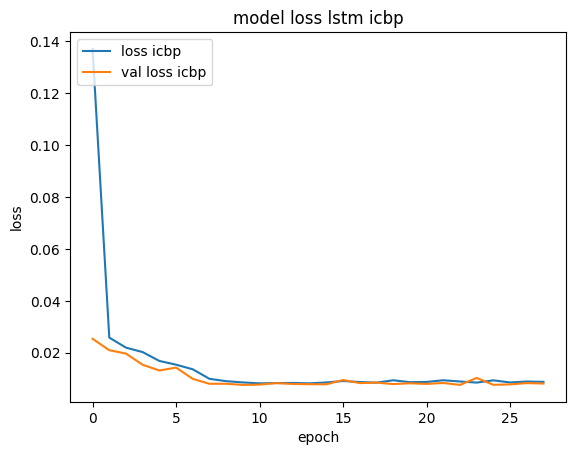

In [32]:
plt.plot(history_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_icbp_model.history['val_loss'], label = 'val loss icbp')
plt.title('model loss lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp', dpi=3600)

## JSMR

In [33]:
#get data and normalize data
df_jsmr = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr = reset_index_data(df_jsmr)
#data to supervised
jsmr_X, jsmr_y = split_sequence(df_jsmr, 1)
#split to train and test
X_train_jsmr, X_test_jsmr, y_train_jsmr, y_test_jsmr = train_test_split(jsmr_X, jsmr_y, test_size=0.33, random_state=42)

X_train_jsmr = reshape_data(X_train_jsmr,1)
X_test_jsmr = reshape_data(X_test_jsmr,1)


In [34]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,16,200]
model_jsmr,history_jsmr_model,  = train_vanila_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 8)                 320       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
108/108 [==============================] - 2s 5ms/step - loss: 0.2632 - mae: 0.2632 - val_loss: 0.1644 - val_mae: 0.1644
Epoch 2/200
108/108 [==============================] - 0s 2ms/step - loss: 0.1689 - mae: 0.1689 - val_loss: 0.1643 - val_mae: 0.1643
Epoch 3/200
108/108 [==============================] - 0s 3ms/step - loss: 0.1692 - mae: 0.1692 - val_loss: 0.1635 - val_mae: 0.1635
Epoch 4/200
108/108 [==============================] 

In [35]:
preds_jsmr = model_jsmr.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr,y_test_jsmr,'jsmr',4)

34/34 [==============================] - 0s 3ms/step
Matriks score for jsmr
mae score: 0.17465907486019128
r2 score -13358005685127.617
mape score 0.29335692354117066
rmse score 0.2178466651547627
round_up
mae score: 0.1747
r2 score -13358005685127.617
mape score 0.2934
rmse score 0.2178


In [36]:
preds_jsmr_train = model_jsmr.predict(X_train_jsmr)
matriks_evaluate(preds_jsmr_train,y_train_jsmr,'jsmr',4)

68/68 [==============================] - 0s 2ms/step
Matriks score for jsmr
mae score: 0.16784709574665194
r2 score 0.0
mape score 0.28191554130795876
rmse score 0.21275222390136744
round_up
mae score: 0.1678
r2 score 0.0
mape score 0.2819
rmse score 0.2128


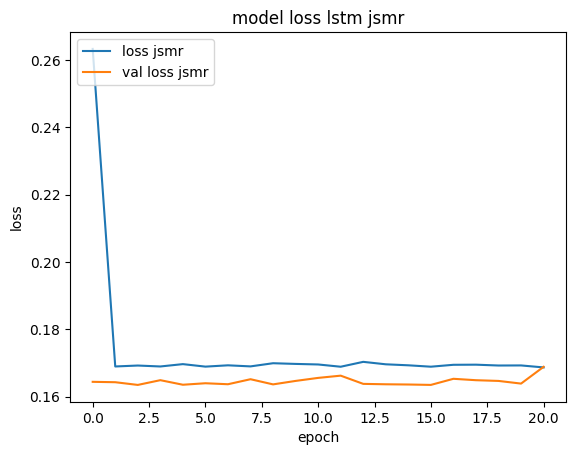

In [37]:
plt.plot(history_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr', dpi=3600)

# BIDIRECTIONAL LSTM

In [38]:
def train_bidirectional_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_bidirectional_lstm = Sequential([
    Bidirectional(LSTM(neuron, activation=activation),input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_bidirectional_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_bidirectional_lstm.summary()
    history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_bidirectional_lstm, history_bidirectional_lstm

#time 41.8
    

## ANTM

In [39]:
cfg_antm = [8,'relu',2,1,0.1,8,200]
model_bidirectional_antm,history_antm_model_bidirectional,  = train_bidirectional_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 16)               640       
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
216/216 [==============================] - 5s 6ms/step - loss: 0.0354 - mae: 0.0354 - val_loss: 0.0172 - val_mae: 0.0172
Epoch 2/200
216/216 [==============================] - 1s 4ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 3/200
216/216 [==============================] - 1s 4ms/step - loss: 0.0214 - mae: 0.0214 - val_loss: 0.0263 - val

In [40]:
preds_antm_bidirectional = model_bidirectional_antm.predict(X_test_antm)
matriks_evaluate(preds_antm_bidirectional,y_test_antm,'antm',4)

34/34 [==============================] - 1s 2ms/step
Matriks score for antm
mae score: 0.011821629664757463
r2 score 0.9910410561387006
mape score 0.05208952341802816
rmse score 0.018744882872918082
round_up
mae score: 0.0118
r2 score 0.991
mape score 0.0521
rmse score 0.0187


In [41]:
preds_antm_bidirectional_train = model_bidirectional_antm.predict(X_train_antm)
matriks_evaluate(preds_antm_bidirectional_train,y_train_antm,'antm',4)

68/68 [==============================] - 0s 3ms/step
Matriks score for antm
mae score: 0.011534306461135463
r2 score 0.9911648423093073
mape score 0.055254914440462204
rmse score 0.018023710219139694
round_up
mae score: 0.0115
r2 score 0.9912
mape score 0.0553
rmse score 0.018


In [42]:
# Matriks score for antm
# mae score: 0.008232755712539704
# r2 score 0.9956862906506637
# mape score 0.04528757310273332
# rmse score 0.013190786339141062

In [43]:
# Matriks score for icbp
pembulatan(0.008232755712539704
,4)
pembulatan(0.9956862906506637,4)
pembulatan(0.04528757310273332,4)
pembulatan(0.013190786339141062,4)

0.0132

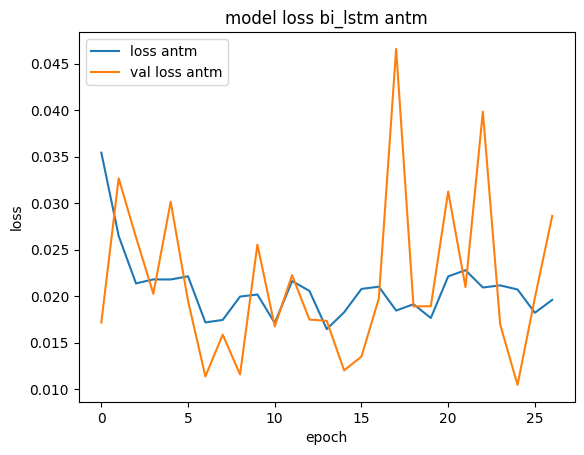

In [44]:
plt.plot(history_antm_model_bidirectional.history['loss'], label='loss antm')
plt.plot(history_antm_model_bidirectional.history['val_loss'], label = 'val loss antm')
plt.title('model loss bi_lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm_bidirection', dpi=3600)

## ASII

In [45]:
cfg_asii = [32,'relu',3,1,0.01,8,150]
model_bidirectional_asii,history_asii_model_bidirectional,  = train_bidirectional_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 64)               8704      
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
216/216 [==============================] - 4s 6ms/step - loss: 0.0473 - mae: 0.0473 - val_loss: 0.0306 - val_mae: 0.0306
Epoch 2/150
216/216 [==============================] - 1s 6ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0271 - val_mae: 0.0271
Epoch 3/150
216/216 [==============================] - 1s 5ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0531 -

In [ ]:
preds_asii_bidirectional = model_bidirectional_asii.predict(X_test_asii)
matriks_evaluate(preds_asii_bidirectional,y_test_asii,'asii',4)

In [ ]:
preds_asii_bidirectional_train = model_bidirectional_asii.predict(X_train_asii)
matriks_evaluate(preds_asii_bidirectional_train,y_train_asii,'asii',4)

In [ ]:
plt.plot(history_asii_model_bidirectional.history['loss'], label='loss asii')
plt.plot(history_asii_model_bidirectional.history['val_loss'], label = 'val loss asii')
plt.title('model loss bi_lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii_bidirection', dpi=3600)

## ICBP

In [ ]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,16,200]
model_bidirectional_icbp,history_icbp_model_bidirectional,  = train_bidirectional_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

In [ ]:
preds_icbp_bidirectional = model_bidirectional_icbp.predict(X_test_icbp)
matriks_evaluate(preds_icbp_bidirectional,y_test_icbp,'icbp',4)

In [ ]:
preds_icbp_bidirectional_train = model_bidirectional_icbp.predict(X_train_icbp)
matriks_evaluate(preds_icbp_bidirectional_train,y_train_icbp,'icbp',4)

In [ ]:
plt.plot(history_icbp_model_bidirectional.history['loss'], label='loss icbp')
plt.plot(history_icbp_model_bidirectional.history['val_loss'], label = 'val loss icbp')
plt.title('model loss bi_lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp_bidirection', dpi=3600)

## JSMR

In [ ]:
#get data and normalize data
df_jsmr = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr = reset_index_data(df_jsmr)
#data to supervised
jsmr_X, jsmr_y = split_sequence(df_jsmr, 1)
#split to train and test
X_train_jsmr, X_test_jsmr, y_train_jsmr, y_test_jsmr = train_test_split(jsmr_X, jsmr_y, test_size=0.33, random_state=42)

X_train_jsmr = reshape_data(X_train_jsmr,1)
X_test_jsmr = reshape_data(X_test_jsmr,1)


# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,16,200]
model_bidirectional_jsmr,history_jsmr_model_bidirectional,  = train_bidirectional_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

In [ ]:
preds_jsmr_bidirectional = model_bidirectional_jsmr.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr_bidirectional,y_test_jsmr,'jsmr',4)

In [ ]:
preds_jsmr_bidirectional_train = model_bidirectional_jsmr.predict(X_train_jsmr)
matriks_evaluate(preds_jsmr_bidirectional_train,y_train_jsmr,'jsmr',4)

In [ ]:
plt.plot(history_jsmr_model_bidirectional.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model_bidirectional.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss bi_lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr_bidirection', dpi=3600)

# CNN-LSTM

In [ ]:
from keras.layers import Flatten 
from keras.layers import TimeDistributed 
from keras.layers.convolutional import Conv1D 
from keras.layers.convolutional import MaxPooling1D

In [ ]:
def train_cnn_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps,n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_cnn_lstm = Sequential()
    model_cnn_lstm.add(TimeDistributed(Conv1D(64,1,activation=activation), input_shape=(None,n_steps,n_features)))
    model_cnn_lstm.add(TimeDistributed(MaxPooling1D()))
    model_cnn_lstm.add(TimeDistributed(Flatten()))
    model_cnn_lstm.add(LSTM(neuron, activation=activation))
    model_cnn_lstm.add(Dense(1))
    model_cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_cnn_lstm.summary()
    history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_cnn_lstm, history_cnn_lstm

#time 41.8
    

In [ ]:
def reshape_data_cnn(X,N_FEATURES, N_SEQ, N_STEPS):
    X = X.reshape(X.shape[0],N_SEQ,N_STEPS,N_FEATURES)
    return X

## ANTM

In [ ]:
#get data and normalize data
df_antm_cnn = normalize_data(data_close.antm,'antm')
#reset index
df_antm_cnn = reset_index_data(df_antm_cnn)
#data to supervised
antm_X_cnn, antm_y_cnn = split_sequence(df_antm_cnn, 2)
#split to train and test
X_train_antm_cnn, X_test_antm_cnn, y_train_antm_cnn, y_test_antm_cnn = train_test_split(antm_X_cnn, antm_y_cnn, test_size=0.33, random_state=44)

X_train_antm_cnn = reshape_data_cnn(X_train_antm_cnn,1,1,2)
X_test_antm_cnn = reshape_data_cnn(X_test_antm_cnn,1,1,2)

In [ ]:
cfg_antm_cnn = [8,'relu',2,1,0.1,8,200]
model_cnn_antm,history_cnn_antm_model,  = train_cnn_lstm(X_train_antm_cnn,y_train_antm_cnn,cfg_antm_cnn)

In [ ]:
preds_antm_cnn_lstm = model_cnn_antm.predict(X_test_antm_cnn)
matriks_evaluate(preds_antm_cnn_lstm,y_test_antm_cnn,'antm',4)

In [ ]:
preds_antm_cnn_lstm_train = model_cnn_antm.predict(X_train_antm_cnn)
matriks_evaluate(preds_antm_cnn_lstm_train,y_train_antm_cnn,'antm',4)

In [ ]:
plt.plot(history_cnn_antm_model.history['loss'], label='loss antm')
plt.plot(history_cnn_antm_model.history['val_loss'], label = 'val loss antm')
plt.title('model loss cnn_lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm_cnn', dpi=3600)

## ASII

In [ ]:
#get data and normalize data
df_asii_cnn = normalize_data(data_close.asii,'asii')
#reset index
df_asii_cnn = reset_index_data(df_asii_cnn)
#data to supervised
asii_X_cnn, asii_y_cnn = split_sequence(df_asii_cnn, 3)
#split to train and test
X_train_asii_cnn, X_test_asii_cnn, y_train_asii_cnn, y_test_asii_cnn = train_test_split(asii_X_cnn, asii_y_cnn, test_size=0.33, random_state=44)

X_train_asii_cnn = reshape_data_cnn(X_train_asii_cnn,1,1,3)
X_test_asii_cnn = reshape_data_cnn(X_test_asii_cnn,1,1,3)

In [ ]:
cfg_asii_cnn = [32,'relu',3,1,0.1,8,150]
model_cnn_asii,history_cnn_asii_model,  = train_cnn_lstm(X_train_asii_cnn,y_train_asii_cnn,cfg_asii_cnn)

In [ ]:
preds_asii_cnn_lstm = model_cnn_asii.predict(X_test_asii_cnn)
matriks_evaluate(preds_asii_cnn_lstm,y_test_asii_cnn,'asii',4)

In [ ]:
preds_asii_cnn_lstm_train = model_cnn_asii.predict(X_train_asii_cnn)
matriks_evaluate(preds_asii_cnn_lstm_train,y_train_asii_cnn,'asii',4)

In [ ]:
plt.plot(history_cnn_asii_model.history['loss'], label='loss asii')
plt.plot(history_cnn_asii_model.history['val_loss'], label = 'val loss asii')
plt.title('model loss cnn_lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii_cnn', dpi=3600)

## ICBP

In [ ]:
#get data and normalize data
df_icbp_cnn = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp_cnn = reset_index_data(df_icbp_cnn)
#data to supervised
icbp_X_cnn, icbp_y_cnn = split_sequence(df_icbp_cnn, 2)
#split to train and test
X_train_icbp_cnn, X_test_icbp_cnn, y_train_icbp_cnn, y_test_icbp_cnn = train_test_split(icbp_X_cnn, icbp_y_cnn, test_size=0.33, random_state=44)

X_train_icbp_cnn = reshape_data_cnn(X_train_icbp_cnn,1,1,2)
X_test_icbp_cnn = reshape_data_cnn(X_test_icbp_cnn,1,1,2)

In [ ]:
cfg_icbp_cnn = [8,'relu',2,1,0.1,16,200]
model_cnn_icbp,history_cnn_icbp_model,  = train_cnn_lstm(X_train_icbp_cnn,y_train_icbp_cnn,cfg_icbp_cnn)

In [ ]:
preds_icbp_cnn_lstm = model_cnn_icbp.predict(X_test_icbp_cnn)
matriks_evaluate(preds_icbp_cnn_lstm,y_test_icbp_cnn,'icbp',4)

In [ ]:
preds_icbp_cnn_lstm_train = model_cnn_icbp.predict(X_train_icbp_cnn)
matriks_evaluate(preds_icbp_cnn_lstm_train,y_train_icbp_cnn,'icbp',4)

In [ ]:
plt.plot(history_cnn_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_cnn_icbp_model.history['val_loss'], label = 'val loss icbp')
plt.title('model loss cnn_lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp_cnn', dpi=3600)

## JSMR

In [ ]:
#get data and normalize data
df_jsmr_cnn = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr_cnn = reset_index_data(df_jsmr_cnn)
#data to supervised
jsmr_X_cnn, jsmr_y_cnn = split_sequence(df_jsmr_cnn, 4)
#split to train and test
X_train_jsmr_cnn, X_test_jsmr_cnn, y_train_jsmr_cnn, y_test_jsmr_cnn = train_test_split(jsmr_X_cnn, jsmr_y_cnn, test_size=0.33, random_state=44)

X_train_jsmr_cnn = reshape_data_cnn(X_train_jsmr_cnn,1,2,2)
X_test_jsmr_cnn = reshape_data_cnn(X_test_jsmr_cnn,1,2,2)

In [ ]:
cfg_jsmr_cnn = [8,'relu',2,1,0.1,16,200]
model_cnn_jsmr,history_cnn_jsmr_model,  = train_cnn_lstm(X_train_jsmr_cnn,y_train_jsmr_cnn,cfg_jsmr_cnn)

In [ ]:
preds_jsmr_cnn_lstm = model_cnn_jsmr.predict(X_test_jsmr_cnn)
matriks_evaluate(preds_jsmr_cnn_lstm,y_test_jsmr_cnn,'jsmr',4)

In [ ]:
preds_jsmr_cnn_lstm_train = model_cnn_jsmr.predict(X_train_jsmr_cnn)
matriks_evaluate(preds_jsmr_cnn_lstm_train,y_train_jsmr_cnn,'jsmr',4)

In [ ]:
plt.plot(history_cnn_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_cnn_jsmr_model.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss cnn_lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr_cnn', dpi=3600)

# CONVLSTM

In [ ]:
def train_conv_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps,n_seq,n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_conv_lstm = Sequential()
    model_conv_lstm.add(ConvLSTM2D(neuron,(1,2),activation=activation, input_shape=(n_seq,1,n_steps,n_features)))
    model_conv_lstm.add(Flatten())
    model_conv_lstm.add(Dense(1))
    model_conv_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_conv_lstm.summary()
    history_conv_lstm = model_conv_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_conv_lstm, history_conv_lstm

#time 41.8
    

In [ ]:
def reshape_data_conv(X,N_FEATURES, N_SEQ,N_ROWS, N_STEPS):
    X = X.reshape(X.shape[0],N_SEQ,N_ROWS,N_STEPS,N_FEATURES)
    return X

## ANTM

In [ ]:
#get data and normalize data
df_antm_conv = normalize_data(data_close.antm,'antm')
#reset index
df_antm_conv = reset_index_data(df_antm_conv)
#data to supervised
antm_X_conv, antm_y_conv = split_sequence(df_antm_conv, 2)
#split to train and test
X_train_antm_conv, X_test_antm_conv, y_train_antm_conv, y_test_antm_conv = train_test_split(antm_X_conv, antm_y_conv, test_size=0.33, random_state=42)

X_train_antm_conv = reshape_data_conv(X_train_antm_conv,1,1,1,2)
X_test_antm_conv = reshape_data_conv(X_test_antm_conv,1,1,1,2)

In [ ]:
cfg_antm_conv = [8,'relu',2,1,1,0.1,8,200]
model_conv_antm,history_conv_antm_model,  = train_conv_lstm(X_train_antm_conv,y_train_antm_conv,cfg_antm_conv)

In [ ]:
preds_antm_conv_lstm = model_conv_antm.predict(X_test_antm_conv)
matriks_evaluate(preds_antm_conv_lstm,y_test_antm_conv,'antm',4)

In [ ]:
preds_antm_conv_lstm_train = model_conv_antm.predict(X_train_antm_conv)
matriks_evaluate(preds_antm_conv_lstm_train,y_train_antm_conv,'antm',4)

In [ ]:
plt.plot(history_conv_antm_model.history['loss'], label='loss antm')
plt.plot(history_conv_antm_model.history['val_loss'], label = 'val loss antm')
plt.title('model loss conv_lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm_conv', dpi=3600)

## ASII

In [ ]:
#get data and normalize data
df_asii_conv = normalize_data(data_close.asii,'asii')
#reset index
df_asii_conv = reset_index_data(df_asii_conv)
#data to supervised
asii_X_conv, asii_y_conv = split_sequence(df_asii_conv, 3)
#split to train and test
X_train_asii_conv, X_test_asii_conv, y_train_asii_conv, y_test_asii_conv = train_test_split(asii_X_conv, asii_y_conv, test_size=0.33, random_state=42)

X_train_asii_conv = reshape_data_conv(X_train_asii_conv,1,1,1,3)
X_test_asii_conv = reshape_data_conv(X_test_asii_conv,1,1,1,3)

In [ ]:
cfg_asii_conv = [32,'relu',3,1,1,0.1,8,150]
model_conv_asii,history_conv_asii_model,  = train_conv_lstm(X_train_asii_conv,y_train_asii_conv,cfg_asii_conv)

In [ ]:
preds_asii_conv_lstm = model_conv_asii.predict(X_test_asii_conv)
matriks_evaluate(preds_asii_conv_lstm,y_test_asii_conv,'asii',4)

In [ ]:
preds_asii_conv_lstm_train = model_conv_asii.predict(X_train_asii_conv)
matriks_evaluate(preds_asii_conv_lstm_train,y_train_asii_conv,'asii',4)

In [ ]:
plt.plot(history_conv_asii_model.history['loss'], label='loss asii')
plt.plot(history_conv_asii_model.history['val_loss'], label = 'val loss asii')
plt.title('model loss conv_lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii_conv', dpi=3600)

## ICBP

In [ ]:
#get data and normalize data
df_icbp_conv = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp_conv = reset_index_data(df_icbp_conv)
#data to supervised
icbp_X_conv, icbp_y_conv = split_sequence(df_icbp_conv, 2)
#split to train and test
X_train_icbp_conv, X_test_icbp_conv, y_train_icbp_conv, y_test_icbp_conv = train_test_split(icbp_X_conv, icbp_y_conv, test_size=0.33, random_state=42)

X_train_icbp_conv = reshape_data_conv(X_train_icbp_conv,1,1,1,2)
X_test_icbp_conv = reshape_data_conv(X_test_icbp_conv,1,1,1,2)

In [ ]:
cfg_icbp_conv = [8,'relu',2,1,1,0.1,16,200]
model_conv_icbp,history_conv_icbp_model,  = train_conv_lstm(X_train_icbp_conv,y_train_icbp_conv,cfg_icbp_conv)

In [ ]:
preds_icbp_conv_lstm = model_conv_icbp.predict(X_test_icbp_conv)
matriks_evaluate(preds_icbp_conv_lstm,y_test_icbp_conv,'icbp',4)

In [ ]:
preds_icbp_conv_lstm_train = model_conv_icbp.predict(X_train_icbp_conv)
matriks_evaluate(preds_icbp_conv_lstm_train,y_train_icbp_conv,'icbp',4)

In [ ]:
plt.plot(history_conv_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_conv_icbp_model.history['val_loss'], label = 'val loss icbp')
plt.title('model loss conv_lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp_conv', dpi=3600)

## JSMR

In [ ]:
#get data and normalize data
df_jsmr_conv = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr_conv = reset_index_data(df_jsmr_conv)
#data to supervised
jsmr_X_conv, jsmr_y_conv = split_sequence(df_jsmr_conv, 4)
#split to train and test
X_train_jsmr_conv, X_test_jsmr_conv, y_train_jsmr_conv, y_test_jsmr_conv = train_test_split(jsmr_X_conv, jsmr_y_conv, test_size=0.33, random_state=42)

X_train_jsmr_conv = reshape_data_conv(X_train_jsmr_conv,1,1,1,4)
X_test_jsmr_conv = reshape_data_conv(X_test_jsmr_conv,1,1,1,4)

In [ ]:
cfg_jsmr_conv = [8,'relu',4,1,1,0.1,16,200]
model_conv_jsmr,history_conv_jsmr_model  = train_conv_lstm(X_train_jsmr_conv,y_train_jsmr_conv,cfg_jsmr_conv)

In [ ]:
preds_jsmr_conv_lstm = model_conv_jsmr.predict(X_test_jsmr_conv)
matriks_evaluate(preds_jsmr_conv_lstm,y_test_jsmr_conv,'jsmr',4)

In [ ]:
preds_jsmr_conv_lstm_train = model_conv_jsmr.predict(X_train_jsmr_conv)
matriks_evaluate(preds_jsmr_conv_lstm_train,y_train_jsmr_conv,'jsmr',4)

In [ ]:
plt.plot(history_conv_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_conv_jsmr_model.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss conv_lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr_conv', dpi=3600)

# RNN

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

def train_rnn(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_rnn = Sequential([
    SimpleRNN(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_rnn.summary()
    history_model_rnn = model_rnn.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_rnn, history_model_rnn

#time 41.8
    

## ANTM

In [ ]:
#get data and normalize data
df_antm_rnn = normalize_data(data_close.antm,'antm')
#reset index
df_antm_rnn = reset_index_data(df_antm_rnn)
#data to supervised
antm_X_rnn, antm_y_rnn = split_sequence(df_antm_rnn, 2)
#split to train and test
X_train_antm_rnn, X_test_antm_rnn, y_train_antm_rnn, y_test_antm_rnn = train_test_split(antm_X_rnn, antm_y_rnn, test_size=0.33, random_state=42)

X_train_antm_rnn = reshape_data(X_train_antm_rnn,1)
X_test_antm_rnn = reshape_data(X_test_antm_rnn,1)


In [ ]:
cfg_antm_rnn = [8,'relu',2,1,0.1,8,200]
model_antm_rnn,history_antm_model_rnn,  = train_rnn(X_train_antm_rnn,y_train_antm_rnn,cfg_antm_rnn)

In [ ]:
preds_antm_rnn = model_antm_rnn.predict(X_test_antm_rnn)
matriks_evaluate(preds_antm_rnn,y_test_antm_rnn,'antm',4)

In [ ]:
preds_antm_rnn_train = model_antm_rnn.predict(X_train_antm_rnn)
matriks_evaluate(preds_antm_rnn_train,y_train_antm_rnn,'antm',4)

In [ ]:
# Matriks score for antm
pembulatan(0.010741172328190532,2)
pembulatan(0.9918942103762897,2)
pembulatan(0.060096347557924944,2)
pembulatan(0.018061080505563522,2)

In [ ]:
plt.plot(history_antm_model_rnn.history['loss'], label='loss rnn antm')
plt.plot(history_antm_model_rnn.history['val_loss'], label = 'val loss rnn antm')
plt.title('model loss rnn lstm antm')
plt.ylabel('loss rnn')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss rnn_antm', dpi=3600)

## ASII

In [ ]:
#get data and normalize data
df_asii_rnn = normalize_data(data_close.asii,'asii')
#reset index
df_asii_rnn = reset_index_data(df_asii_rnn)
#data to supervised
asii_X_rnn, asii_y_rnn = split_sequence(df_asii_rnn, 3)
#split to train and test
X_train_asii_rnn, X_test_asii_rnn, y_train_asii_rnn, y_test_asii_rnn = train_test_split(asii_X_rnn, asii_y_rnn, test_size=0.33, random_state=42)

X_train_asii_rnn = reshape_data(X_train_asii_rnn,1)
X_test_asii_rnn = reshape_data(X_test_asii_rnn,1)


In [ ]:
cfg_asii_rnn = [32,'relu',3,1,0.01,8,150]
model_asii_rnn,history_asii_model_rnn  = train_rnn(X_train_asii_rnn,y_train_asii_rnn,cfg_asii_rnn)

In [ ]:
preds_asii_rnn = model_asii_rnn.predict(X_test_asii_rnn)
matriks_evaluate(preds_asii_rnn,y_test_asii_rnn,'asii',4)

In [ ]:
preds_asii_rnn_train = model_asii_rnn.predict(X_train_asii_rnn)
matriks_evaluate(preds_asii_rnn_train,y_train_asii_rnn,'asii',4)

In [ ]:
plt.plot(history_asii_model_rnn.history['loss'], label='loss rnn asii')
plt.plot(history_asii_model_rnn.history['val_loss'], label = 'val loss rnn asii')
plt.title('model loss rnn lstm asii')
plt.ylabel('loss rnn')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss rnn_asii', dpi=3600)

## ICBP

In [ ]:
#get data and normalize data
df_icbp_rnn = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp_rnn = reset_index_data(df_icbp_rnn)
#data to supervised
icbp_X_rnn, icbp_y_rnn = split_sequence(df_icbp_rnn, 1)
#split to train and test
X_train_icbp_rnn, X_test_icbp_rnn, y_train_icbp_rnn, y_test_icbp_rnn = train_test_split(icbp_X_rnn, icbp_y_rnn, test_size=0.33, random_state=42)

X_train_icbp_rnn = reshape_data(X_train_icbp_rnn,1)
X_test_icbp_rnn = reshape_data(X_test_icbp_rnn,1)


In [ ]:
cfg_icbp_rnn = [8,'relu',1,1,0.01,16,200]
model_icbp_rnn,history_icbp_model_rnn  = train_rnn(X_train_icbp_rnn,y_train_icbp_rnn,cfg_icbp_rnn)

In [ ]:
preds_icbp_rnn = model_icbp_rnn.predict(X_test_icbp_rnn)
matriks_evaluate(preds_icbp_rnn,y_test_icbp_rnn,'icbp',4)

In [ ]:
preds_icbp_rnn_train = model_icbp_rnn.predict(X_train_icbp_rnn)
matriks_evaluate(preds_icbp_rnn_train,y_train_icbp_rnn,'icbp',4)

In [ ]:
plt.plot(history_icbp_model_rnn.history['loss'], label='loss rnn icbp')
plt.plot(history_icbp_model_rnn.history['val_loss'], label = 'val loss rnn icbp')
plt.title('model loss rnn lstm icbp')
plt.ylabel('loss rnn')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss rnn_icbp', dpi=3600)

## JSMR

In [ ]:
#get data and normalize data
df_jsmr_rnn = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr_rnn = reset_index_data(df_jsmr_rnn)
#data to supervised
jsmr_X_rnn, jsmr_y_rnn = split_sequence(df_jsmr_rnn, 1)
#split to train and test
X_train_jsmr_rnn, X_test_jsmr_rnn, y_train_jsmr_rnn, y_test_jsmr_rnn = train_test_split(jsmr_X_rnn, jsmr_y_rnn, test_size=0.33, random_state=42)

X_train_jsmr_rnn = reshape_data(X_train_jsmr_rnn,1)
X_test_jsmr_rnn = reshape_data(X_test_jsmr_rnn,1)


In [ ]:
cfg_jsmr_rnn = [8,'relu',1,1,0.01,16,200]
model_jsmr_rnn,history_jsmr_model_rnn  = train_rnn(X_train_jsmr_rnn,y_train_jsmr_rnn,cfg_jsmr_rnn)

In [ ]:
preds_jsmr_rnn = model_jsmr_rnn.predict(X_test_jsmr_rnn)
matriks_evaluate(preds_jsmr_rnn,y_test_jsmr_rnn,'jsmr',4)

In [ ]:
preds_jsmr_rnn_train = model_jsmr_rnn.predict(X_train_jsmr_rnn)
matriks_evaluate(preds_jsmr_rnn_train,y_train_jsmr_rnn,'jsmr',4)

In [ ]:
plt.plot(history_jsmr_model_rnn.history['loss'], label='loss rnn jsmr')
plt.plot(history_jsmr_model_rnn.history['val_loss'], label = 'val loss rnn jsmr')
plt.title('model loss rnn lstm jsmr')
plt.ylabel('loss rnn')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss rnn_jsmr', dpi=3600)

# Komparasi berdasarkan Data saham

## ANTM

In [ ]:
plt.plot(history_antm_model.history['loss'], label='loss antm')
plt.plot(history_antm_model_bidirectional.history['loss'], label='loss bidirectional antm')
plt.plot(history_cnn_antm_model.history['loss'], label='loss cnn-lstm antm')
plt.plot(history_conv_antm_model.history['loss'], label='loss convlstm antm')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_antm', dpi=1200)

In [ ]:
plt.plot(history_antm_model.history['loss'], label='loss antm')
plt.plot(history_antm_model_bidirectional.history['loss'], label='loss bidirectional antm')
plt.plot(history_cnn_antm_model.history['loss'], label='loss cnn-lstm antm')
plt.plot(history_conv_antm_model.history['loss'], label='loss convlstm antm')
plt.plot(history_antm_model_rnn.history['loss'], label='loss rnn antm')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_antm', dpi=3600)

## ASII

In [ ]:
plt.plot(history_asii_model.history['loss'], label='loss asii')
plt.plot(history_asii_model_bidirectional.history['loss'], label='loss bidirectional asii')
plt.plot(history_cnn_asii_model.history['loss'], label='loss cnn-lstm asii')
plt.plot(history_conv_asii_model.history['loss'], label='loss convlstm asii')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_asii', dpi=1200)

In [ ]:
plt.plot(history_asii_model.history['loss'], label='loss asii')
plt.plot(history_asii_model_bidirectional.history['loss'], label='loss bidirectional asii')
plt.plot(history_cnn_asii_model.history['loss'], label='loss cnn-lstm asii')
plt.plot(history_conv_asii_model.history['loss'], label='loss convlstm asii')
plt.plot(history_asii_model_rnn.history['loss'], label='loss rnn asii')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_asii', dpi=3600)

## ICBP

In [ ]:
plt.plot(history_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_icbp_model_bidirectional.history['loss'], label='loss bidirectional icbp')
plt.plot(history_cnn_icbp_model.history['loss'], label='loss cnn-lstm icbp')
plt.plot(history_conv_icbp_model.history['loss'], label='loss convlstm icbp')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_icbp', dpi=1200)

In [ ]:
plt.plot(history_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_icbp_model_bidirectional.history['loss'], label='loss bidirectional icbp')
plt.plot(history_cnn_icbp_model.history['loss'], label='loss cnn-lstm icbp')
plt.plot(history_conv_icbp_model.history['loss'], label='loss convlstm icbp')
plt.plot(history_icbp_model_rnn.history['loss'], label='loss icbp rnn')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_icbp', dpi=1200)

## JSMR

In [ ]:
plt.plot(history_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model_bidirectional.history['loss'], label='loss bidirectional jsmr')
plt.plot(history_cnn_jsmr_model.history['loss'], label='loss cnn-lstm jsmr')
plt.plot(history_conv_jsmr_model.history['loss'], label='loss convlstm jsmr')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_jsmr', dpi=1200)

In [ ]:
plt.plot(history_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model_bidirectional.history['loss'], label='loss bidirectional jsmr')
plt.plot(history_cnn_jsmr_model.history['loss'], label='loss cnn-lstm jsmr')
plt.plot(history_conv_jsmr_model.history['loss'], label='loss convlstm jsmr')
plt.plot(history_jsmr_model_rnn.history['loss'], label='loss rnn jsmr')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_jsmr', dpi=3600)

# KOMPARASI METRIKS EVALUASI Berdasarkan saham

In [ ]:
def plot_metriks(data,title):
    names = list(data.keys())
    values = list(data.values())
    plt.title(title)
    plt.bar(range(len(data)), values, tick_label=names)
    plt.savefig(title, dpi=1200)
    plt.show()

## ANTM

In [ ]:
mae_antm_model = {'model\nlstm\nantm':mean_absolute_error(preds_antm, y_test_antm),'model\nbidirectional\nlstm':mean_absolute_error(preds_antm_bidirectional, y_test_antm),'model\ncnn\nlstm':mean_absolute_error(preds_antm_cnn_lstm, y_test_antm_cnn),'model\nconvlstm':mean_absolute_error(preds_antm_conv_lstm, y_test_antm_conv)}

mape_antm_model = {'model\nlstm\nantm':mean_absolute_percentage_error(preds_antm, y_test_antm),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_antm_bidirectional, y_test_antm),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_antm_cnn_lstm, y_test_antm_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_antm_conv_lstm, y_test_antm_conv)}

rmse_antm_model = {'model\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm, y_test_antm)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_antm_bidirectional, y_test_antm)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_antm_cnn_lstm, y_test_antm_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_antm_conv_lstm, y_test_antm_conv))}

r2_antm_model = {'model\nlstm\nantm':r2_score(preds_antm, y_test_antm),'model\nbidirectional\nlstm':r2_score(preds_antm_bidirectional, y_test_antm),'model\ncnn\nlstm':r2_score(preds_antm_cnn_lstm, y_test_antm_cnn),'model\nconvlstm':r2_score(preds_antm_conv_lstm, y_test_antm_conv)} 


In [ ]:
mae_antm_model_rnn = {'model\nlstm\nantm':mean_absolute_error(preds_antm, y_test_antm),'model\nbidirectional\nlstm':mean_absolute_error(preds_antm_bidirectional, y_test_antm),'model\ncnn\nlstm':mean_absolute_error(preds_antm_cnn_lstm, y_test_antm_cnn),'model\nconvlstm':mean_absolute_error(preds_antm_conv_lstm, y_test_antm_conv),'model\nrnn':mean_absolute_error(preds_antm_rnn, y_test_antm_rnn)}

mape_antm_model_rnn = {'model\nlstm\nantm':mean_absolute_percentage_error(preds_antm, y_test_antm),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_antm_bidirectional, y_test_antm),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_antm_cnn_lstm, y_test_antm_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_antm_conv_lstm, y_test_antm_conv),'model\nrnn':mean_absolute_percentage_error(preds_antm_rnn, y_test_antm_rnn)}

rmse_antm_model_rnn = {'model\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm, y_test_antm)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_antm_bidirectional, y_test_antm)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_antm_cnn_lstm, y_test_antm_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_antm_conv_lstm, y_test_antm_conv)),'model\nrnn':np.sqrt(mean_squared_error(preds_antm_rnn, y_test_antm_rnn))}

r2_antm_model_rnn = {'model\nlstm\nantm':r2_score(preds_antm, y_test_antm),'model\nbidirectional\nlstm':r2_score(preds_antm_bidirectional, y_test_antm),'model\ncnn\nlstm':r2_score(preds_antm_cnn_lstm, y_test_antm_cnn),'model\nconvlstm':r2_score(preds_antm_conv_lstm, y_test_antm_conv),'model\nrnn':r2_score(preds_antm_rnn, y_test_antm_rnn)} 


In [ ]:
print("sorted mae")
mae_antm_sorted = dict(sorted(mae_antm_model.items(),key=lambda item: item[1]))
print(mae_antm_sorted)
print("sorted rmse")
rmse_antm_sorted = dict(sorted(rmse_antm_model.items(),key=lambda item: item[1]))
print(rmse_antm_sorted)
print("sorted mape")
mape_antm_sorted = dict(sorted(mape_antm_model.items(),key=lambda item: item[1]))
print(mape_antm_sorted)
print("sorted r2")
r2_antm_sorted = dict(sorted(r2_antm_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_antm_sorted)

In [ ]:
sorted mae
{'model_lstm_antm': 0.00792330651423234, 'model_convlstm': 0.008979813932403035, 'model_bidirectional_lstm': 0.010083131140679802, 'model_cnn_lstm': 0.010867278830534548}
sorted rmse
{'model_lstm_antm': 0.013645817005473931, 'model_bidirectional_lstm': 0.015164592497452231, 'model_convlstm': 0.015586941316141424, 'model_cnn_lstm': 0.016741492746486068}
sorted mape
{'model_lstm_antm': 0.03875965710274557, 'model_convlstm': 0.04170634238737134, 'model_cnn_lstm': 0.064639021568424, 'model_bidirectional_lstm': 0.07193945105344311}
sorted r2
{'model_lstm_antm': 0.9951434537789272, 'model_convlstm': 0.9940666469044093, 'model_bidirectional_lstm': 0.9937322524708159, 'model_cnn_lstm': 0.993089376712622}

In [ ]:
print("sorted mae with rnn")
mae_antm_sorted_rnn = dict(sorted(mae_antm_model_rnn.items(),key=lambda item: item[1]))
print(mae_antm_sorted_rnn)
print("sorted rmse with rnn")
rmse_antm_sorted_rnn = dict(sorted(rmse_antm_model_rnn.items(),key=lambda item: item[1]))
print(rmse_antm_sorted_rnn)
print("sorted mape with rnn")
mape_antm_sorted_rnn = dict(sorted(mape_antm_model_rnn.items(),key=lambda item: item[1]))
print(mape_antm_sorted_rnn)
print("sorted r2 with rnn")
r2_antm_sorted_rnn = dict(sorted(r2_antm_model_rnn.items(),key=lambda item: item[1] ,reverse=True))
print(r2_antm_sorted_rnn)

In [ ]:
sorted mae with rnn
{'model_lstm_antm': 0.00792330651423234, 'model_convlstm': 0.008979813932403035, 'model_bidirectional_lstm': 0.010083131140679802, 'model_rnn': 0.010478654205229577, 'model_cnn_lstm': 0.010867278830534548}
sorted rmse with rnn
{'model_lstm_antm': 0.013645817005473931, 'model_bidirectional_lstm': 0.015164592497452231, 'model_convlstm': 0.015586941316141424, 'model_rnn': 0.015870582918009215, 'model_cnn_lstm': 0.016741492746486068}
sorted mape with rnn
{'model_lstm_antm': 0.03875965710274557, 'model_convlstm': 0.04170634238737134, 'model_rnn': 0.05973322659954254, 'model_cnn_lstm': 0.064639021568424, 'model_bidirectional_lstm': 0.07193945105344311}
sorted r2 with rnn
{'model_lstm_antm': 0.9951434537789272, 'model_convlstm': 0.9940666469044093, 'model_rnn': 0.9938764452484279, 'model_bidirectional_lstm': 0.9937322524708159, 'model_cnn_lstm': 0.993089376712622}

In [ ]:
plot_metriks(mae_antm_model,"plot mae comparison of lstm model by antm stock")
plot_metriks(mape_antm_model,"plot mape comparison of lstm model by antm stock")
plot_metriks(rmse_antm_model,"plot rmse comparison of lstm model by antm stock")
plot_metriks(r2_antm_model,"plot r2 comparison of lstm model by antm stock")

## ASII

In [ ]:
mae_asii_model = {'model\nlstm\nasii':mean_absolute_error(preds_asii, y_test_asii),'model\nbidirectional\nlstm':mean_absolute_error(preds_asii_bidirectional, y_test_asii),'model\ncnn\nlstm':mean_absolute_error(preds_asii_cnn_lstm, y_test_asii_cnn),'model\nconvlstm':mean_absolute_error(preds_asii_conv_lstm, y_test_asii_conv)}

mape_asii_model = {'model\nlstm\nasii':mean_absolute_percentage_error(preds_asii, y_test_asii),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_asii_bidirectional, y_test_asii),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_asii_cnn_lstm, y_test_asii_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_asii_conv_lstm, y_test_asii_conv)}

rmse_asii_model = {'model\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii, y_test_asii)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_asii_bidirectional, y_test_asii)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_asii_cnn_lstm, y_test_asii_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_asii_conv_lstm, y_test_asii_conv))}

r2_asii_model = {'model\nlstm\nasii':r2_score(preds_asii, y_test_asii),'model\nbidirectional\nlstm':r2_score(preds_asii_bidirectional, y_test_asii),'model\ncnn\nlstm':r2_score(preds_asii_cnn_lstm, y_test_asii_cnn),'model\nconvlstm':r2_score(preds_asii_conv_lstm, y_test_asii_conv)} 


In [ ]:
mae_asii_model_rnn = {'model\nlstm\nasii':mean_absolute_error(preds_asii, y_test_asii),'model\nbidirectional\nlstm':mean_absolute_error(preds_asii_bidirectional, y_test_asii),'model\ncnn\nlstm':mean_absolute_error(preds_asii_cnn_lstm, y_test_asii_cnn),'model\nconvlstm':mean_absolute_error(preds_asii_conv_lstm, y_test_asii_conv),'model\nrnn':mean_absolute_error(preds_asii_rnn, y_test_asii_rnn)}

mape_asii_model_rnn = {'model\nlstm\nasii':mean_absolute_percentage_error(preds_asii, y_test_asii),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_asii_bidirectional, y_test_asii),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_asii_cnn_lstm, y_test_asii_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_asii_conv_lstm, y_test_asii_conv),'model\nrnn':mean_absolute_percentage_error(preds_asii_rnn, y_test_asii_rnn)}

rmse_asii_model_rnn = {'model\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii, y_test_asii)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_asii_bidirectional, y_test_asii)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_asii_cnn_lstm, y_test_asii_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_asii_conv_lstm, y_test_asii_conv)),'model\nrnn':np.sqrt(mean_squared_error(preds_asii_rnn, y_test_asii_rnn))}

r2_asii_model_rnn = {'model\nlstm\nasii':r2_score(preds_asii, y_test_asii),'model\nbidirectional\nlstm':r2_score(preds_asii_bidirectional, y_test_asii),'model\ncnn\nlstm':r2_score(preds_asii_cnn_lstm, y_test_asii_cnn),'model\nconvlstm':r2_score(preds_asii_conv_lstm, y_test_asii_conv),'model\nrnn':r2_score(preds_asii_rnn, y_test_asii_rnn)} 


In [ ]:
print("sorted mae")
mae_asii_sorted = dict(sorted(mae_asii_model.items(),key=lambda item: item[1]))
print(mae_asii_sorted)
print("sorted rmse")
rmse_asii_sorted = dict(sorted(rmse_asii_model.items(),key=lambda item: item[1]))
print(rmse_asii_sorted)
print("sorted mape")
mape_asii_sorted = dict(sorted(mape_asii_model.items(),key=lambda item: item[1]))
print(mape_asii_sorted)
print("sorted r2")
r2_asii_sorted = dict(sorted(r2_asii_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_asii_sorted)

In [ ]:
sorted mae
{'model_lstm_asii': 0.015557469024060277, 'model_bidirectional_lstm': 0.015557469024060277, 'model_convlstm': 0.017502466607205686, 'model_cnn_lstm': 0.025615471457232676}
sorted rmse
{'model_lstm_asii': 0.020195572184998862, 'model_bidirectional_lstm': 0.020195572184998862, 'model_convlstm': 0.024368460318503666, 'model_cnn_lstm': 0.034314310609913}
sorted mape
{'model_lstm_asii': 0.03653063088132113, 'model_bidirectional_lstm': 0.03653063088132113, 'model_convlstm': 0.04371383500044023, 'model_cnn_lstm': 0.09404178861648758}
sorted r2
{'model_lstm_asii': 0.989093802259257, 'model_bidirectional_lstm': 0.989093802259257, 'model_convlstm': 0.9845989847390949, 'model_cnn_lstm': 0.9706884687600915}

In [ ]:
print("sorted mae")
mae_asii_sorted = dict(sorted(mae_asii_model.items(),key=lambda item: item[1]))
print(mae_asii_sorted)
print("sorted rmse")
rmse_asii_sorted = dict(sorted(rmse_asii_model.items(),key=lambda item: item[1]))
print(rmse_asii_sorted)
print("sorted mape")
mape_asii_sorted = dict(sorted(mape_asii_model.items(),key=lambda item: item[1]))
print(mape_asii_sorted)
print("sorted r2")
r2_asii_sorted = dict(sorted(r2_asii_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_asii_sorted)

In [ ]:
print("sorted mae with rnn")
mae_asii_sorted_rnn = dict(sorted(mae_asii_model_rnn.items(),key=lambda item: item[1]))
print(mae_asii_sorted_rnn)
print("sorted rmse with rnn")
rmse_asii_sorted_rnn = dict(sorted(rmse_asii_model_rnn.items(),key=lambda item: item[1]))
print(rmse_asii_sorted_rnn)
print("sorted mape with rnn")
mape_asii_sorted_rnn = dict(sorted(mape_asii_model_rnn.items(),key=lambda item: item[1]))
print(mape_asii_sorted_rnn)
print("sorted r2 with rnn")
r2_asii_sorted_rnn = dict(sorted(r2_asii_model_rnn.items(),key=lambda item: item[1] ,reverse=True))
print(r2_asii_sorted_rnn)

In [ ]:
sorted mae with rnn
{'model_lstm_asii': 0.015557469024060277, 'model_bidirectional_lstm': 0.015557469024060277, 'model_rnn': 0.016422883454755, 'model_convlstm': 0.017502466607205686, 'model_cnn_lstm': 0.025615471457232676}
sorted rmse with rnn
{'model_lstm_asii': 0.020195572184998862, 'model_bidirectional_lstm': 0.020195572184998862, 'model_rnn': 0.02181020099368869, 'model_convlstm': 0.024368460318503666, 'model_cnn_lstm': 0.034314310609913}
sorted mape with rnn
{'model_lstm_asii': 0.03653063088132113, 'model_bidirectional_lstm': 0.03653063088132113, 'model_convlstm': 0.04371383500044023, 'model_rnn': 0.060887043105124335, 'model_cnn_lstm': 0.09404178861648758}
sorted r2 with rnn
{'model_lstm_asii': 0.989093802259257, 'model_bidirectional_lstm': 0.989093802259257, 'model_rnn': 0.9887014235433372, 'model_convlstm': 0.9845989847390949, 'model_cnn_lstm': 0.9706884687600915}

In [ ]:
plot_metriks(mae_asii_model,"plot mae comparison of lstm model by asii stock")
plot_metriks(mape_asii_model,"plot mape comparison of lstm model by asii stock")
plot_metriks(rmse_asii_model,"plot rmse comparison of lstm model by asii stock")
plot_metriks(r2_asii_model,"plot r2 comparison of lstm model by asii stock")

## ICBP

In [ ]:
mae_icbp_model = {'model\nlstm\nicbp':mean_absolute_error(preds_icbp, y_test_icbp),'model\nbidirectional\nlstm':mean_absolute_error(preds_icbp_bidirectional, y_test_icbp),'model\ncnn\nlstm':mean_absolute_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model\nconvlstm':mean_absolute_error(preds_icbp_conv_lstm, y_test_icbp_conv)}

mape_icbp_model = {'model\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp, y_test_icbp),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_icbp_bidirectional, y_test_icbp),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_icbp_conv_lstm, y_test_icbp_conv),}

rmse_icbp_model = {'model\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp, y_test_icbp)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_icbp_bidirectional, y_test_icbp)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_icbp_cnn_lstm, y_test_icbp_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_icbp_conv_lstm, y_test_icbp_conv))}

r2_icbp_model = {'model\nlstm\nicbp':r2_score(preds_icbp, y_test_icbp),'model\nbidirectional\nlstm':r2_score(preds_icbp_bidirectional, y_test_icbp),'model\ncnn\nlstm':r2_score(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model\nconvlstm':r2_score(preds_icbp_conv_lstm, y_test_icbp_conv)} 


In [ ]:
mae_icbp_model_rnn = {'model\nlstm\nicbp':mean_absolute_error(preds_icbp, y_test_icbp),'model\nbidirectional\nlstm':mean_absolute_error(preds_icbp_bidirectional, y_test_icbp),'model\ncnn\nlstm':mean_absolute_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model\nconvlstm':mean_absolute_error(preds_icbp_conv_lstm, y_test_icbp_conv),'model\nrnn':mean_absolute_error(preds_icbp_rnn, y_test_icbp_rnn)}

mape_icbp_model_rnn = {'model\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp, y_test_icbp),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_icbp_bidirectional, y_test_icbp),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_icbp_conv_lstm, y_test_icbp_conv),'model\nrnn':mean_absolute_percentage_error(preds_icbp_rnn, y_test_icbp_rnn)}

rmse_icbp_model_rnn = {'model\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp, y_test_icbp)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_icbp_bidirectional, y_test_icbp)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_icbp_cnn_lstm, y_test_icbp_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_icbp_conv_lstm, y_test_icbp_conv)),'model\nrnn':np.sqrt(mean_squared_error(preds_icbp_rnn, y_test_icbp_rnn))}

r2_icbp_model_rnn = {'model\nlstm\nicbp':r2_score(preds_icbp, y_test_icbp),'model\nbidirectional\nlstm':r2_score(preds_icbp_bidirectional, y_test_icbp),'model\ncnn\nlstm':r2_score(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model\nconvlstm':r2_score(preds_icbp_conv_lstm, y_test_icbp_conv),'model\nrnn':r2_score(preds_icbp_rnn, y_test_icbp_rnn)} 


In [ ]:
print("sorted mae")
mae_icbp_sorted = dict(sorted(mae_icbp_model.items(),key=lambda item: item[1]))
print(mae_icbp_sorted)
print("sorted rmse")
rmse_icbp_sorted = dict(sorted(rmse_icbp_model.items(),key=lambda item: item[1]))
print(rmse_icbp_sorted)
print("sorted mape")
mape_icbp_sorted = dict(sorted(mape_icbp_model.items(),key=lambda item: item[1]))
print(mape_icbp_sorted)
print("sorted r2")
r2_icbp_sorted = dict(sorted(r2_icbp_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_icbp_sorted)

In [ ]:
sorted mae
{'model_lstm_icbp': 0.007648942956731045, 'model_bidirectional_lstm': 0.007648942956731045, 'model_convlstm': 0.008220928696773062, 'model_cnn_lstm': 0.009556431471032486}
sorted rmse
{'model_lstm_icbp': 0.011935327146399034, 'model_bidirectional_lstm': 0.011935327146399034, 'model_convlstm': 0.01194496498690776, 'model_cnn_lstm': 0.014560457730640828}
sorted mape
{'model_lstm_icbp': 0.030918351015072346, 'model_bidirectional_lstm': 0.030918351015072346, 'model_convlstm': 0.03313670493828922, 'model_cnn_lstm': 0.040972101408647904}
sorted r2
{'model_lstm_icbp': 0.9981788616019397, 'model_bidirectional_lstm': 0.9981788616019397, 'model_convlstm': 0.9981439306391389, 'model_cnn_lstm': 0.9970308200983052}

In [ ]:
print("sorted mae with rnn")
mae_icbp_sorted_rnn = dict(sorted(mae_icbp_model_rnn.items(),key=lambda item: item[1]))
print(mae_icbp_sorted_rnn)
print("sorted rmse with rnn")
rmse_icbp_sorted_rnn = dict(sorted(rmse_icbp_model_rnn.items(),key=lambda item: item[1]))
print(rmse_icbp_sorted_rnn)
print("sorted mape with rnn")
mape_icbp_sorted_rnn = dict(sorted(mape_icbp_model_rnn.items(),key=lambda item: item[1]))
print(mape_icbp_sorted_rnn)
print("sorted r2 with rnn")
r2_icbp_sorted_rnn = dict(sorted(r2_icbp_model_rnn.items(),key=lambda item: item[1] ,reverse=True))
print(r2_icbp_sorted_rnn)

In [ ]:
sorted mae with rnn
{'model_lstm_icbp': 0.007648942956731045, 'model_bidirectional_lstm': 0.007648942956731045, 'model_rnn': 0.007757285320692215, 'model_convlstm': 0.008220928696773062, 'model_cnn_lstm': 0.009556431471032486}
sorted rmse with rnn
{'model_lstm_icbp': 0.011935327146399034, 'model_bidirectional_lstm': 0.011935327146399034, 'model_convlstm': 0.01194496498690776, 'model_rnn': 0.01200580053690187, 'model_cnn_lstm': 0.014560457730640828}
sorted mape with rnn
{'model_rnn': 0.028233230604920338, 'model_lstm_icbp': 0.030918351015072346, 'model_bidirectional_lstm': 0.030918351015072346, 'model_convlstm': 0.03313670493828922, 'model_cnn_lstm': 0.040972101408647904}
sorted r2 with rnn
{'model_rnn': 0.9982025783014885, 'model_lstm_icbp': 0.9981788616019397, 'model_bidirectional_lstm': 0.9981788616019397, 'model_convlstm': 0.9981439306391389, 'model_cnn_lstm': 0.9970308200983052}

In [ ]:
plot_metriks(mae_icbp_model,"plot mae comparison of lstm model by icbp stock")
plot_metriks(mape_icbp_model,"plot mape comparison of lstm model by icbp stock")
plot_metriks(rmse_icbp_model,"plot rmse comparison of lstm model by icbp stock")
plot_metriks(r2_icbp_model,"plot r2 comparison of lstm model by icbp stock")

## JSMR

In [ ]:
mae_jsmr_model = {'model\nlstm\njsmr':mean_absolute_error(preds_jsmr, y_test_jsmr),'model\nbidirectional\nlstm':mean_absolute_error(preds_jsmr_bidirectional, y_test_jsmr),'model\ncnn\nlstm':mean_absolute_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model\nconvlstm':mean_absolute_error(preds_jsmr_conv_lstm, y_test_jsmr_conv)}

mape_jsmr_model = {'model\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr, y_test_jsmr),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_jsmr_bidirectional, y_test_jsmr),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),}

rmse_jsmr_model = {'model\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr, y_test_jsmr)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_jsmr_bidirectional, y_test_jsmr)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_jsmr_conv_lstm, y_test_jsmr_conv))}

r2_jsmr_model = {'model\nlstm\njsmr':r2_score(preds_jsmr, y_test_jsmr),'model\nbidirectional\nlstm':r2_score(preds_jsmr_bidirectional, y_test_jsmr),'model\ncnn\nlstm':r2_score(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model\nconvlstm':r2_score(preds_jsmr_conv_lstm, y_test_jsmr_conv)} 


In [ ]:
mae_jsmr_model_rnn = {'model\nlstm\njsmr':mean_absolute_error(preds_jsmr, y_test_jsmr),'model\nbidirectional\nlstm':mean_absolute_error(preds_jsmr_bidirectional, y_test_jsmr),'model\ncnn\nlstm':mean_absolute_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model\nconvlstm':mean_absolute_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),'model\nrnn':mean_absolute_error(preds_jsmr_rnn, y_test_jsmr_rnn)}

mape_jsmr_model_rnn = {'model\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr, y_test_jsmr),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_jsmr_bidirectional, y_test_jsmr),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),'model\nrnn':mean_absolute_percentage_error(preds_jsmr_rnn, y_test_jsmr_rnn)}

rmse_jsmr_model_rnn = {'model\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr, y_test_jsmr)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_jsmr_bidirectional, y_test_jsmr)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_jsmr_conv_lstm, y_test_jsmr_conv)),'model\nrnn':np.sqrt(mean_squared_error(preds_jsmr_rnn, y_test_jsmr_rnn))}

r2_jsmr_model_rnn = {'model\nlstm\njsmr':r2_score(preds_jsmr, y_test_jsmr),'model\nbidirectional\nlstm':r2_score(preds_jsmr_bidirectional, y_test_jsmr),'model\ncnn\nlstm':r2_score(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model\nconvlstm':r2_score(preds_jsmr_conv_lstm, y_test_jsmr_conv),'model\nrnn':r2_score(preds_jsmr_rnn, y_test_jsmr_rnn)} 


In [ ]:
print("sorted mae")
mae_jsmr_sorted = dict(sorted(mae_jsmr_model.items(),key=lambda item: item[1]))
print(mae_jsmr_sorted)
print("sorted rmse")
rmse_jsmr_sorted = dict(sorted(rmse_jsmr_model.items(),key=lambda item: item[1]))
print(rmse_jsmr_sorted)
print("sorted mape")
mape_jsmr_sorted = dict(sorted(mape_jsmr_model.items(),key=lambda item: item[1]))
print(mape_jsmr_sorted)
print("sorted r2")
r2_jsmr_sorted = dict(sorted(r2_jsmr_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_jsmr_sorted)

In [ ]:
sorted mae
{'model_lstm_jsmr': 0.011625160650538133, 'model_bidirectional_lstm': 0.011625160650538133, 'model_cnn_lstm': 0.014865195266480814, 'model_convlstm': 0.1709639568691877}
sorted rmse
{'model_lstm_jsmr': 0.016253116954927965, 'model_bidirectional_lstm': 0.016253116954927965, 'model_cnn_lstm': 0.0199532391334831, 'model_convlstm': 0.2167639950236958}
sorted mape
{'model_lstm_jsmr': 0.034380635932369126, 'model_bidirectional_lstm': 0.034380635932369126, 'model_cnn_lstm': 0.037042561270746684, 'model_convlstm': 0.28156389013646044}
sorted r2
{'model_lstm_jsmr': 0.9941700031256803, 'model_bidirectional_lstm': 0.9941700031256803, 'model_cnn_lstm': 0.9902441332698643, 'model_convlstm': -3306390113773.7236}

In [ ]:
print("sorted mae with rnn")
mae_jsmr_sorted_rnn = dict(sorted(mae_jsmr_model_rnn.items(),key=lambda item: item[1]))
print(mae_jsmr_sorted_rnn)
print("sorted rmse with rnn")
rmse_jsmr_sorted_rnn = dict(sorted(rmse_jsmr_model_rnn.items(),key=lambda item: item[1]))
print(rmse_jsmr_sorted_rnn)
print("sorted mape with rnn")
mape_jsmr_sorted_rnn = dict(sorted(mape_jsmr_model_rnn.items(),key=lambda item: item[1]))
print(mape_jsmr_sorted_rnn)
print("sorted r2 with rnn")
r2_jsmr_sorted_rnn = dict(sorted(r2_jsmr_model_rnn.items(),key=lambda item: item[1] ,reverse=True))
print(r2_jsmr_sorted_rnn)

In [ ]:
sorted mae with rnn
{'model_rnn': 0.011223198774113652, 'model_lstm_jsmr': 0.011625160650538133, 'model_bidirectional_lstm': 0.011625160650538133, 'model_cnn_lstm': 0.014865195266480814, 'model_convlstm': 0.1709639568691877}
sorted rmse with rnn
{'model_rnn': 0.015972328218525875, 'model_lstm_jsmr': 0.016253116954927965, 'model_bidirectional_lstm': 0.016253116954927965, 'model_cnn_lstm': 0.0199532391334831, 'model_convlstm': 0.2167639950236958}
sorted mape with rnn
{'model_rnn': 0.02776045680249453, 'model_lstm_jsmr': 0.034380635932369126, 'model_bidirectional_lstm': 0.034380635932369126, 'model_cnn_lstm': 0.037042561270746684, 'model_convlstm': 0.28156389013646044}
sorted r2 with rnn
{'model_rnn': 0.9943931114717062, 'model_lstm_jsmr': 0.9941700031256803, 'model_bidirectional_lstm': 0.9941700031256803, 'model_cnn_lstm': 0.9902441332698643, 'model_convlstm': -3306390113773.7236}

In [ ]:
plot_metriks(mae_jsmr_model,"plot mae comparison of lstm&rnn model by jsmr stock")
plot_metriks(mape_jsmr_model,"plot mape comparison of lstm&rnn model by jsmr stock")
plot_metriks(rmse_jsmr_model,"plot rmse comparison of lstm&rnn model by jsmr stock")
plot_metriks(r2_jsmr_model,"plot r2 comparison of lstm&rnn model by jsmr stock")

# PLOT METRIKS EVALUASI

#### ANTM

In [ ]:
mae_antm_plot = {'mae\nlstm\nantm':mean_absolute_error(preds_antm, y_test_antm),'mae\nbidirectional\nlstm\nantm':mean_absolute_error(preds_antm_bidirectional, y_test_antm),'mae\ncnn\nlstm\nantm':mean_absolute_error(preds_antm_cnn_lstm, y_test_antm_cnn),'mae\nconvlstm\nantm':mean_absolute_error(preds_antm_conv_lstm, y_test_antm_conv),'mae\nrnn\natnm':mean_absolute_error(preds_antm_rnn, y_test_antm_rnn)}

mape_antm_plot = {'mape\nlstm\nantm':mean_absolute_percentage_error(preds_antm, y_test_antm),'mape\nbidirectional\nlstm\nantm':mean_absolute_percentage_error(preds_antm_bidirectional, y_test_antm),'mape\ncnn\nlstm\nantm':mean_absolute_percentage_error(preds_antm_cnn_lstm, y_test_antm_cnn),'mape\nconvlstm\nantm':mean_absolute_percentage_error(preds_antm_conv_lstm, y_test_antm),'mape\nrnn\nantm':mean_absolute_percentage_error(preds_antm_rnn, y_test_antm_rnn)}

rmse_antm_plot = {'rmse\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm, y_test_antm)),'rmse\nbidirectional\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm_bidirectional, y_test_antm)),'rmse\ncnn\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm_cnn_lstm, y_test_antm_cnn)),'convlstm\nantm':np.sqrt(mean_squared_error(preds_antm_conv_lstm, y_test_antm)),'rmse\nrnn\nantm':np.sqrt(mean_squared_error(preds_antm_rnn, y_test_antm_rnn))}

r2_antm_plot = {'r2\nlstm\nantm':r2_score(preds_antm, y_test_antm),'r2\nbidirectional\nlstm\nantm':r2_score(preds_antm_bidirectional, y_test_antm),'r2\ncnn\nlstm\nantm':r2_score(preds_antm_cnn_lstm, y_test_antm_cnn),'r2\nconvlstm\nantm':r2_score(preds_antm_conv_lstm, y_test_antm),'r2\nrnn\nantm':r2_score(preds_antm_rnn, y_test_antm_rnn)} 


In [ ]:
mae_antm = 'Antm Mae'
mape_antm = 'Antm Mape'
rmse_antm = 'Antm Rmse'
r2_antm = 'Antm R2'

In [ ]:
plot_metriks(mae_antm_plot,mae_antm + " Hist plot")

In [ ]:
plot_metriks(mape_antm_plot,mape_antm + " Hist plot")

In [ ]:
plot_metriks(rmse_antm_plot,rmse_antm + " Hist plot")

In [ ]:
plot_metriks(r2_antm_plot,r2_antm +" Hist plot")

#### ASII

In [ ]:
mae_asii_plot = {'mae\nlstm\nasii':mean_absolute_error(preds_asii, y_test_asii),'mae\nbidirectional\nlstm\nasii':mean_absolute_error(preds_asii_bidirectional, y_test_asii),'mae\ncnn\nlstm\nasii':mean_absolute_error(preds_asii_cnn_lstm, y_test_asii_cnn),'mae\nconvlstm\nasii':mean_absolute_error(preds_asii_conv_lstm, y_test_asii_conv),'mae\nrnn\natnm':mean_absolute_error(preds_asii_rnn, y_test_asii_rnn)}

mape_asii_plot = {'mape\nlstm\nasii':mean_absolute_percentage_error(preds_asii, y_test_asii),'mape\nbidirectional\nlstm\nasii':mean_absolute_percentage_error(preds_asii_bidirectional, y_test_asii),'mape\ncnn\nlstm\nasii':mean_absolute_percentage_error(preds_asii_cnn_lstm, y_test_asii_cnn),'mape\nconvlstm\nasii':mean_absolute_percentage_error(preds_asii_conv_lstm, y_test_asii),'mape\nrnn\nasii':mean_absolute_percentage_error(preds_asii_rnn, y_test_asii_rnn)}

rmse_asii_plot = {'rmse\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii, y_test_asii)),'rmse\nbidirectional\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii_bidirectional, y_test_asii)),'rmse\ncnn\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii_cnn_lstm, y_test_asii_cnn)),'convlstm\nasii':np.sqrt(mean_squared_error(preds_asii_conv_lstm, y_test_asii)),'rmse\nrnn\nasii':np.sqrt(mean_squared_error(preds_asii_rnn, y_test_asii_rnn))}

r2_asii_plot = {'r2\nlstm\nasii':r2_score(preds_asii, y_test_asii),'r2\nbidirectional\nlstm\nasii':r2_score(preds_asii_bidirectional, y_test_asii),'r2\ncnn\nlstm\nasii':r2_score(preds_asii_cnn_lstm, y_test_asii_cnn),'r2\nconvlstm\nasii':r2_score(preds_asii_conv_lstm, y_test_asii),'r2\nrnn\nasii':r2_score(preds_asii_rnn, y_test_asii_rnn)} 


In [ ]:
mae_asii = 'Asii Mae'
mape_asii = 'Asii Mape'
rmse_asii = 'Asii Rmse'
r2_asii = 'Asii R2'

In [ ]:
plot_metriks(mae_asii_plot,mae_asii + " Hist plot")

In [ ]:
plot_metriks(mape_asii_plot,mape_asii + " Hist plot")

In [ ]:
plot_metriks(rmse_asii_plot,rmse_asii + " Hist plot")

In [ ]:
plot_metriks(r2_asii_plot,r2_asii +" Hist plot")

#### ICBP

In [ ]:
mae_icbp_plot = {'mae\nlstm\nicbp':mean_absolute_error(preds_icbp, y_test_icbp),'mae\nbidirectional\nlstm\nicbp':mean_absolute_error(preds_icbp_bidirectional, y_test_icbp),'mae\ncnn\nlstm\nicbp':mean_absolute_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'mae\nconvlstm\nicbp':mean_absolute_error(preds_icbp_conv_lstm, y_test_icbp_conv),'mae\nrnn\natnm':mean_absolute_error(preds_icbp_rnn, y_test_icbp_rnn)}

mape_icbp_plot = {'mape\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp, y_test_icbp),'mape\nbidirectional\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp_bidirectional, y_test_icbp),'mape\ncnn\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'mape\nconvlstm\nicbp':mean_absolute_percentage_error(preds_icbp_conv_lstm, y_test_icbp),'mape\nrnn\nicbp':mean_absolute_percentage_error(preds_icbp_rnn, y_test_icbp_rnn)}

rmse_icbp_plot = {'rmse\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp, y_test_icbp)),'rmse\nbidirectional\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp_bidirectional, y_test_icbp)),'rmse\ncnn\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp_cnn_lstm, y_test_icbp_cnn)),'convlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp_conv_lstm, y_test_icbp)),'rmse\nrnn\nicbp':np.sqrt(mean_squared_error(preds_icbp_rnn, y_test_icbp_rnn))}

r2_icbp_plot = {'r2\nlstm\nicbp':r2_score(preds_icbp, y_test_icbp),'r2\nbidirectional\nlstm\nicbp':r2_score(preds_icbp_bidirectional, y_test_icbp),'r2\ncnn\nlstm\nicbp':r2_score(preds_icbp_cnn_lstm, y_test_icbp_cnn),'r2\nconvlstm\nicbp':r2_score(preds_icbp_conv_lstm, y_test_icbp),'r2\nrnn\nicbp':r2_score(preds_icbp_rnn, y_test_icbp_rnn)} 


In [ ]:
mae_icbp = 'Icbp Mae'
mape_icbp = 'Icbp Mape'
rmse_icbp = 'Icbp Rmse'
r2_icbp = 'Icbp R2'

In [ ]:
plot_metriks(mae_icbp_plot,mae_icbp + " Hist plot")

In [ ]:
plot_metriks(mape_icbp_plot,mape_icbp + " Hist plot")

In [ ]:
plot_metriks(rmse_icbp_plot,rmse_icbp + " Hist plot")

In [ ]:
plot_metriks(r2_icbp_plot,r2_icbp +" Hist plot")

#### JSMR

In [ ]:
mae_jsmr_plot = {'mae\nlstm\njsmr':mean_absolute_error(preds_jsmr, y_test_jsmr),'mae\nbidirectional\nlstm\njsmr':mean_absolute_error(preds_jsmr_bidirectional, y_test_jsmr),'mae\ncnn\nlstm\njsmr':mean_absolute_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'mae\nconvlstm\njsmr':mean_absolute_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),'mae\nrnn\natnm':mean_absolute_error(preds_jsmr_rnn, y_test_jsmr_rnn)}

mape_jsmr_plot = {'mape\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr, y_test_jsmr),'mape\nbidirectional\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr_bidirectional, y_test_jsmr),'mape\ncnn\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'mape\nconvlstm\njsmr':mean_absolute_percentage_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),'mape\nrnn\njsmr':mean_absolute_percentage_error(preds_jsmr_rnn, y_test_jsmr_rnn)}

rmse_jsmr_plot = {'rmse\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr, y_test_jsmr)),'rmse\nbidirectional\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr_bidirectional, y_test_jsmr)),'rmse\ncnn\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn)),'convlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr_conv_lstm, y_test_jsmr_conv)),'rmse\nrnn\njsmr':np.sqrt(mean_squared_error(preds_jsmr_rnn, y_test_jsmr_rnn))}

r2_jsmr_plot = {'r2\nlstm\njsmr':r2_score(preds_jsmr, y_test_jsmr),'r2\nbidirectional\nlstm\njsmr':r2_score(preds_jsmr_bidirectional, y_test_jsmr),'r2\ncnn\nlstm\njsmr':r2_score(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'r2\nconvlstm\njsmr':r2_score(preds_jsmr_conv_lstm, y_test_jsmr_conv),'r2\nrnn\njsmr':r2_score(preds_jsmr_rnn, y_test_jsmr_rnn)} 


In [ ]:
mae_jsmr = 'Jsmr Mae'
mape_jsmr = 'Jsmr Mape'
rmse_jsmr = 'Jsmr Rmse'
r2_jsmr = 'Jsmr R2'

In [ ]:
plot_metriks(mae_jsmr_plot,mae_jsmr + " Hist plot")

In [ ]:
plot_metriks(mape_jsmr_plot,mape_jsmr + " Hist plot")

In [ ]:
plot_metriks(rmse_jsmr_plot,rmse_jsmr + " Hist plot")

In [ ]:
plot_metriks(r2_jsmr_plot,r2_jsmr +" Hist plot")